# Preprocess the data

In [20]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing

# I'm importing warnings to ignore a warning librosa throws when reading mp3 files.
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (17, 5)

In [21]:
path = '../data/fma_metadata/'
tracks = pd.read_csv(path + 'tracks.csv', index_col=0, header=[0, 1])

In [22]:
# This code is selecting the small dataset and extracting the features to use in the model.
# It is also separating the tracks into train, validation, and test sets.
small = tracks['set', 'subset'] == 'small'

# Only keep the tracks in the small dataset.
tracks_small = tracks[small]

# Create a column for the track IDs for convenience.
tracks_small['tid'] = tracks_small.index

# FMA has already separated the tracks for into the three sets (train, val, test)
train = tracks_small['set', 'split'] == 'training'
val = tracks_small['set', 'split'] == 'validation'
test = tracks_small['set', 'split'] == 'test'

df_train = tracks_small[train]
df_val = tracks_small[val]
df_test = tracks_small[test]

print('{} training examples'.format(df_train.shape[0]))
print('{} cross validation examples'.format(df_val.shape[0]))
print('{} testing examples'.format(df_test.shape[0]))

print('Genres in the small dataset:')
print(', '.join(tracks.loc[small, ('track', 'genre_top')].unique()))

6400 training examples
800 cross validation examples
800 testing examples
Genres in the small dataset:
Hip-Hop, Pop, Folk, Experimental, Rock, International, Electronic, Instrumental


In [23]:
AUDIO_DIR = '../data/fma_small/'

In [24]:
def get_path(audio_dir, tid):
    """
    Get the path of the audio file of the given track id.
    :param audio_dir: Path to the directory where all the audio files are stored.
    :param tid: Track ID of the audio file we want the path to.
    :return: The path to the audio file.
    """
    # Adds back leading zeros for the track ID we want.
    filename = '{:06d}.mp3'.format(tid)
    # The audio file is stored in folders with the leading three digits of the audio filename.
    return os.path.join(audio_dir, filename[:3], filename)

In [25]:
# Test function works properly
assert get_path(AUDIO_DIR, 2) == '../data/fma_small/000/000002.mp3'

## Feature Extraction: Mel-Spectrogram

The feature I will be extracting from the audio files is the Mel-Spectrogram. I will be storing all the spectrograms in the npz format.

In [26]:
SR = 22050
HOP_LENGTH = 1024
N_FFT = 2048

def log_melspectrogram(tid, *, plot=False, genre_label=''):
    """
    Generate the log melspectrogram using an audio time series. Optionally this function will
    also plot the log melspectrogram.
    :param tid: Track ID of the audio file.
    :param plot: Bool value, when true the log melspectrogram generated will be plotted. 
                 By default this kwarg is set to false.
    :param genre_label: Genre label assosiated with the track.
    :return: The log melspectrogram
    """
    filepath = get_path(AUDIO_DIR, tid)
    
    y, _ = librosa.load(filepath)
    
    melspec = librosa.feature.melspectrogram(y=y, sr=SR, hop_length=HOP_LENGTH, n_fft=N_FFT)

    melspec = librosa.power_to_db(melspec, ref=np.max)

    if plot:
            
        if genre_label != '':
            
            plt.title('Track {} --- Genre: {}'.format(tid, genre_label))
            
        else:
            
            plt.title('Track {}'.format(tid))
            
        librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    return melspec

In [53]:
def batch_create_log_melspectrograms(df):
    """
    Generate the log melspectrograms for all the tracks in the given pandas dataframe.
    :param df: Pandas dataframe containing the tracks to convert to log melspectrograms.
    :return: The array of log melspectrograms for all the tracks in the given dataframe and their genres.
    """
    melspecs = np.empty((0, 128, 640))
    genres = []
    
    for i, (index, row) in enumerate(df.iterrows()):
        
        tid = int(row['tid'])
        
        # Some of the mp3 files were corrupted, so we need a try and except to avoid errors associated
        # with not being able to read in mp3 files.
        try:

            # Generate the log melspectrogram
            melspec = log_melspectrogram(tid)

            # Not all of the melspecs have the same dimensions, therefore, I decided to cut off 
            # anything after 640.
            melspec = melspec[:,:640]

            # So in my experience np.concatenate is much faster than append.
            # Therefore we append the first element and then concatenate after for the 
            # rest of the elements.
            if i == 0:
                melspecs = np.append(melspecs, [melspec], axis=0)
            else:
                melspecs = np.concatenate((melspecs, [melspec]), axis=0)

            # Save genre
            genre = row['encoded_genre']
            genres.append(genre)

            # Progress update
            if (i+1) % 100 == 0:
                print('Finished {} tracks'.format(i+1))
            
        except:
        
            print('Could not proccess track {}'.format(tid))
            continue
            
    melspecs = np.array(melspecs)
    labels = np.array(genres)
    
    return melspecs, labels

## Display a log Melspectrogram

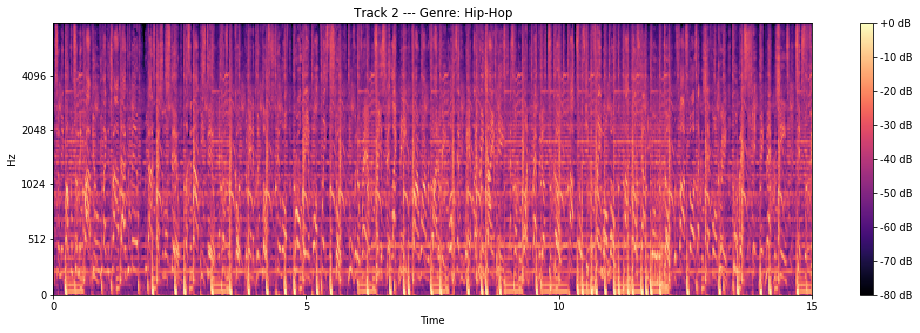

In [36]:
genre = df_train[('track', 'genre_top')].iloc[0]
tid = int(df_train['tid'].iloc[0])
log_melspectrogram(tid, plot=True, genre_label=genre);

## Encode Labels
I'm going to encode the genre labels to make it easier to store in the npz file format.

In [37]:
le = preprocessing.LabelEncoder()
le.fit(df_train[('track', 'genre_top')])
le.classes_

array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype=object)

In [38]:
label_train = le.transform(df_train[('track', 'genre_top')])
label_val = le.transform(df_val[('track', 'genre_top')])
label_test = le.transform(df_test[('track', 'genre_top')])

# Create a column for the encoded genre labels.
df_train['encoded_genre'] = label_train
df_val['encoded_genre'] = label_val
df_test['encoded_genre'] = label_test

## Store all the log Melspectrograms

In [40]:
X_val, y_val = batch_create_log_melspectrograms(df_val)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks


In [41]:
np.savez('../data/melspects_val.npz', X_val=X_val, y_val=y_val)

In [42]:
X_test, y_test = batch_create_log_melspectrograms(df_test)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks


In [43]:
np.savez('../data/melspects_test.npz', X_test=X_test, y_test=y_test)

### Storing the train data:

Since there is so much train data I will be breaking it up into sections to make running the code a little easier on my computer...

In [44]:
df1_train = df_train[:1600]
df2_train = df_train[1600:3200]
df3_train = df_train[3200:4800]
df4_train = df_train[4800:6400]

In [45]:
X_train1, y_train1 = batch_create_log_melspectrograms(df1_train)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks
Finished 1100 tracks
Finished 1200 tracks
Finished 1300 tracks
Finished 1400 tracks
Finished 1500 tracks
Finished 1600 tracks


In [47]:
np.savez('../data/melspects_train1.npz', X_train1=X_train1, y_train1=y_train1)

In [48]:
X_train2, y_train2 = batch_create_log_melspectrograms(df2_train)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks
Finished 1100 tracks
Finished 1200 tracks
Finished 1300 tracks
Finished 1400 tracks
Finished 1500 tracks
Finished 1600 tracks


In [49]:
np.savez('../data/melspects_train2.npz', X_train2=X_train2, y_train2=y_train2)

In [ ]:
X_train3, y_train3 = batch_create_log_melspectrograms(df3_train)

Finished 100 tracks
Finished 200 tracks
Could not proccess track 98565
Could not proccess track 98567
Could not proccess track 98569
Finished 300 tracks
Could not proccess track 99134
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Could not proccess track 108925
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks
Finished 1100 tracks
Finished 1200 tracks
Finished 1300 tracks
Finished 1400 tracks
Finished 1500 tracks


In [ ]:
np.savez('../data/melspects_train3.npz', X_test3=X_train3, y_train3=y_train3)

In [ ]:
X_train4, y_train4 = batch_create_log_melspectrograms(df4_train)

In [ ]:
np.savez('../data/melspects_train4.npz', X_train4=X_train4, y_train4=y_train4)